In [ ]:
%matplotlib inline
!pip install deap update_checker tqdm stopit xgboost
!pip install scikit-mdr skrebate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 160 kB 4.3 MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11956 sha256=e95d8c73be60390e38e4a378742f7f2f729a1b8571b2ee1fb9f73db87adfc85d
  Stored in directory: /root/.cache/pip/wheels/e2/d2/79/eaf81edb391e27c87f51b8ef901ecc85a5363dc96b8b8d71e3
Successfully built stopit
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for scikit-mdr: filename=scikit_MDR-0.4.4-py3-none-any.whl size=14647 sha256=8b503b186ce158dddb2a8febacd809965b01ccfbbcc576d61ef835d834c8cbfd
  Stored in directory: /root/.cache/pip/wheels/32/d0/b5/3ac42d99dd9d9d02b8587d5ebb72b7b137ce0908ccfa5b8fa9
  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29271 sha256=f5e69353541797d9f6aae6ce954024d64ceb2ea1a5115e8c60590ebdd4eb7061
  Stored in directory: /root/.cache/pip/whee


----------------------------------------------------------------------
 
 For n_clusters:  2 
 The average silhouette_score is:  0.5573381106763785 
 Risk:  1581.4932903525798 
----------------------------------------------------------------------


----------------------------------------------------------------------
 
 For n_clusters:  3 
 The average silhouette_score is:  0.6723960462025184 
 Risk:  1224.632462595281 
----------------------------------------------------------------------


----------------------------------------------------------------------
 
 For n_clusters:  4 
 The average silhouette_score is:  0.6177054287646849 
 Risk:  1000.9501738122178 
----------------------------------------------------------------------


----------------------------------------------------------------------
 
 For n_clusters:  5 
 The average silhouette_score is:  0.5298229107619565 
 Risk:  937.7749668282763 
----------------------------------------------------------------------


-

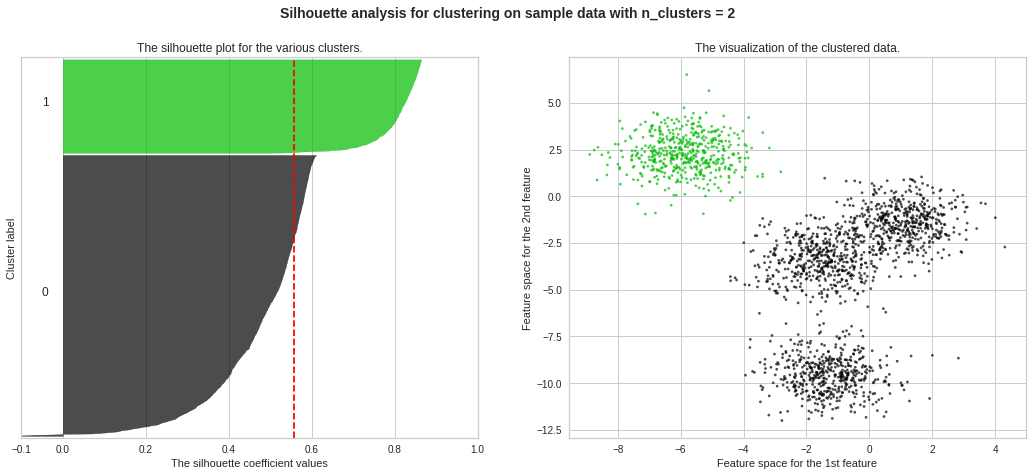

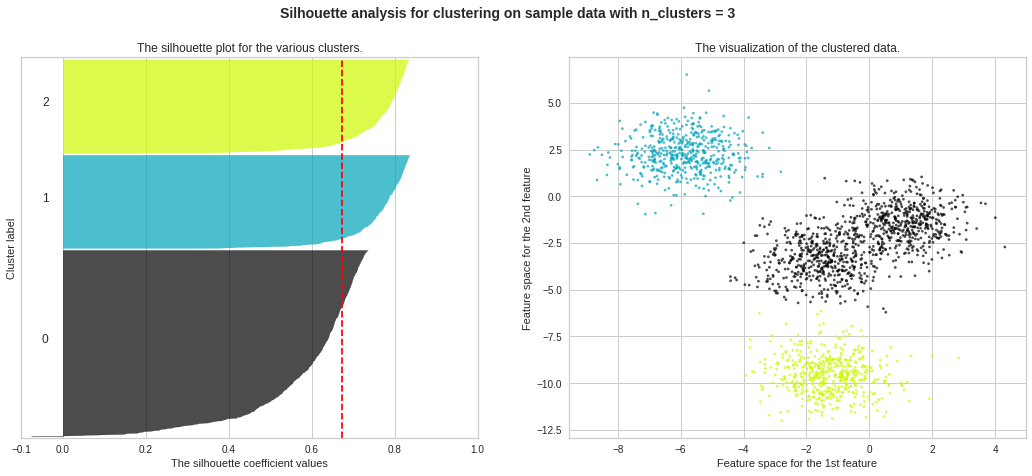

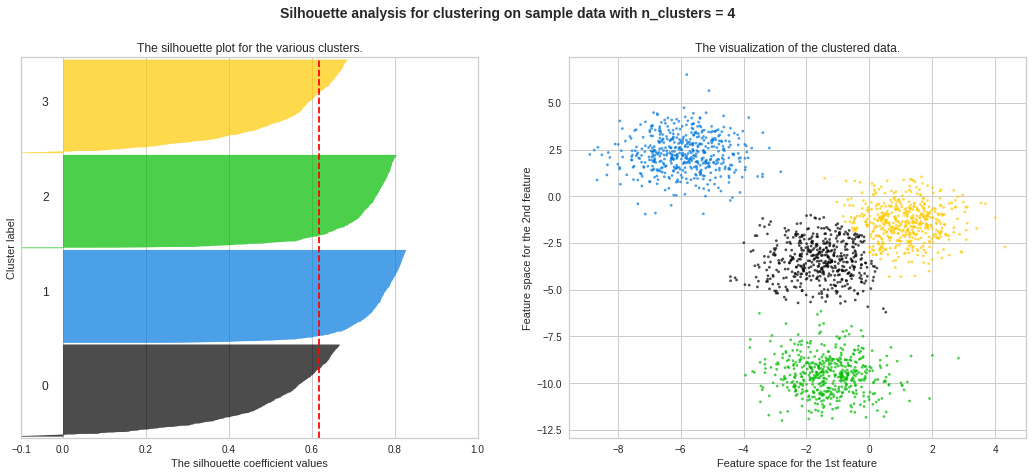

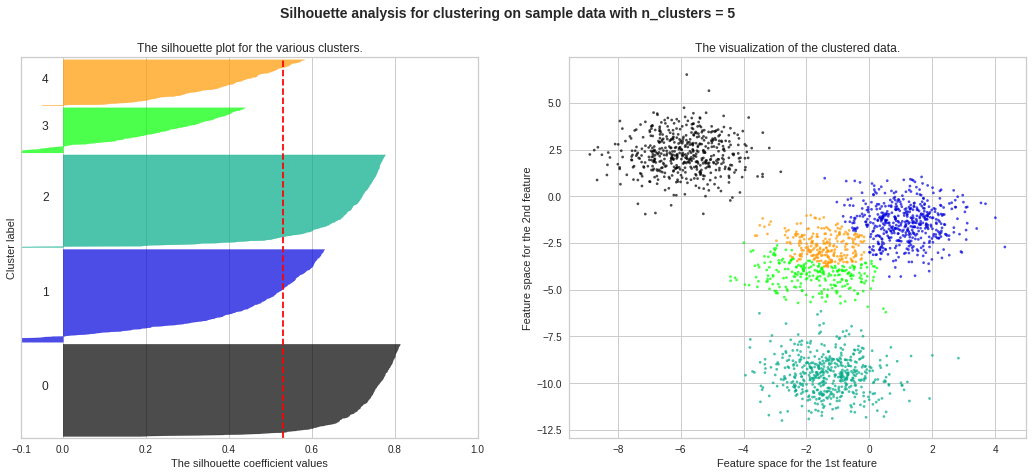

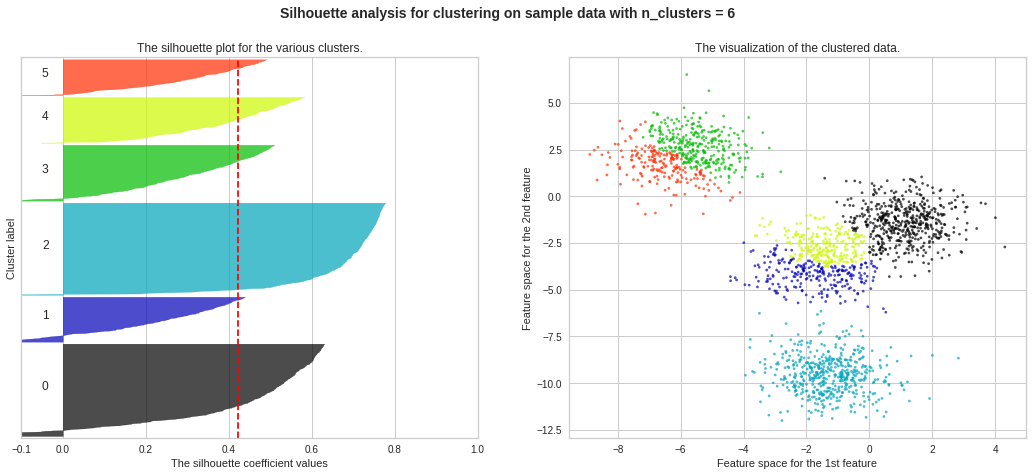

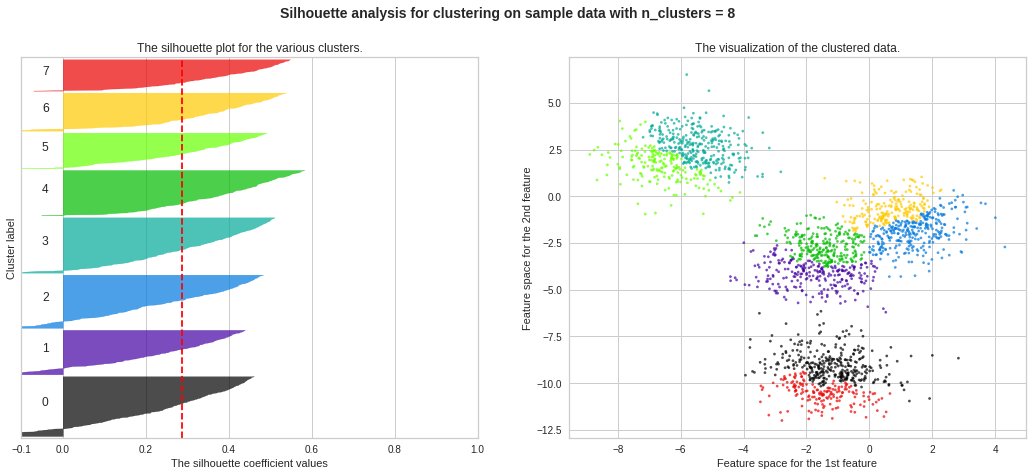

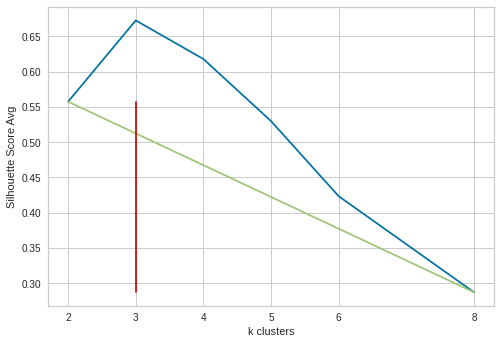

0.0


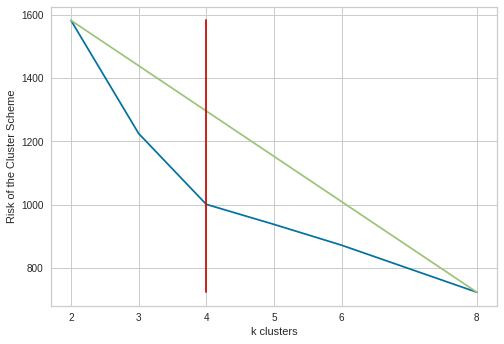

237.39713037681827


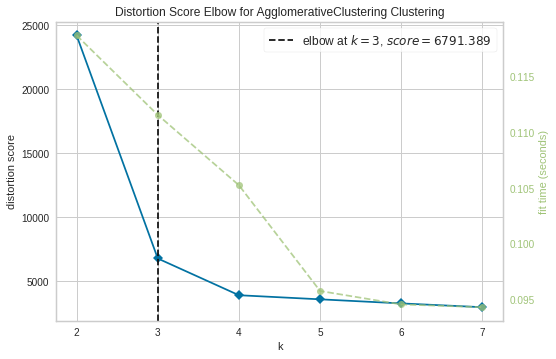

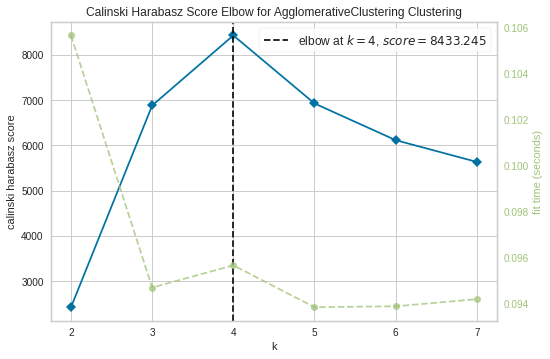

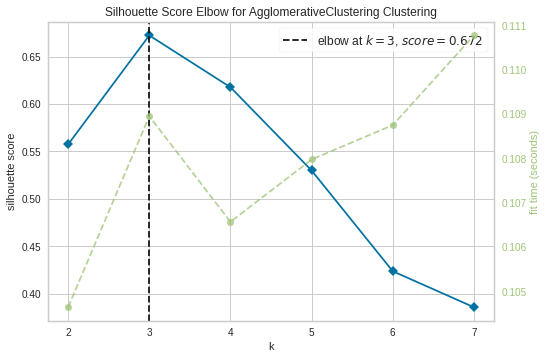

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score, make_scorer
from sklearn.neighbors import NearestNeighbors

from yellowbrick.cluster import KElbowVisualizer

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np

# to plot silhouette average
silhouette_avg_plot = []

# to plot risc curve
risk_plot = []

# Generating the sample data from make_blobs
X, y = make_blobs(
    n_samples=2000,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=2,
)

# determine number of the clusters scheme
# range_n_clusters = range(15,25,1)
range_n_clusters = [2, 3, 4, 5, 6, 8]

# início DTRS - Noberto --------------------------------------------------------
# similarity euclidean distance
def euclidean_distance(xi,xj):
  return np.sqrt(sum(pow(a-b,2) for a, b in zip(xi, xj)))

# normalizar
def normalize(X):
    n = np.linalg.norm(X)
    return X/n

# média das similaridades (val)
def dtrs_val(X):
    sim = []
    # xnorm = normalize(X)
    xnorm = X
    for xi in xnorm:
        for i in range(len(xnorm)):
          xj = xnorm[i]
          sim.append(euclidean_distance(xi,xj))
    # sim = normalize(sim)
    return (1/(len(xnorm)^2))*sum(sim)

# custom loss function
def dtrs_risk(X,y):
    risk = []
    val = dtrs_val(X)
    # xnorm = normalize(X)
    xnorm = X
    for i in range(len(xnorm)):
        xi = xnorm[i]
        for j in range(len(xnorm)):
            xj = xnorm[j]
            sim = euclidean_distance(xi,xj)
            if sim >= val and y[i] == y[j]:
                risk.append(0.5-((sim-val)/(2-2*val)))
            elif sim < val and y[i] == y[j]:
                risk.append(0.5+((val-sim)/(2*val)))
            elif sim >= val and y[i] != y[j]:
                risk.append(0.5+((sim-val)/(2-2*val)))
            elif sim < val and y[i] != y[j]:
                risk.append(0.5-((val-sim)/(2*val)))
    return sum(normalize(risk))
# fim DTRS - Noberto -----------------------------------------------------------


for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_avg_plot.append(silhouette_avg)    

    # Compute DTRS (custom score function)
    risk = dtrs_risk(X,cluster_labels)
    risk_plot.append(risk)

    # print results
    print(
        "\n----------------------------------------------------------------------\n",
        "\n For n_clusters: ", n_clusters,
        "\n The average silhouette_score is: ", silhouette_avg,
        # "\n X:\n",
        # X,
        # "\n len X: ", len(X),
        # "\n X shape (elements, features):", X.shape,
        # "\n y:\n",
        # y,
        # "\n Cluster labels:\n",
        # cluster_labels,
        "\n Risk: ",
        risk,
        "\n----------------------------------------------------------------------\n",
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    # fim

    plt.suptitle(
        "Silhouette analysis for clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )
plt.show()


# plot silhouette average curve
fig = plt.figure()
ax = plt.axes()
x = range_n_clusters
y = silhouette_avg_plot
ax.plot(x, y);
ax.set_ylabel('Silhouette Score Avg')
ax.set_xlabel('k clusters')
ax.set_xticks(x)
rx = np.linspace(x[0],x[len(x)-1],len(x))
ry = np.linspace(y[0],y[len(y)-1],len(y))
ax.plot(rx, ry, '-g');
r = np.array(ry-y)
abs = [n*(-1) if n<0 else n for n in r]
pointElbow = np.full((len(ry)), rx[list(abs).index(max(abs))], dtype=int)
ax.plot(pointElbow, ry, '-r');
plt.show()
print(max(ry-y))

# plot risk curve
fig = plt.figure()
ax = plt.axes()
x = range_n_clusters
y = risk_plot
ax.plot(x, y);
ax.set_ylabel('Risk of the Cluster Scheme')
ax.set_xlabel('k clusters')
ax.set_xticks(x)
rx = np.linspace(x[0],x[len(x)-1],len(x))
ry = np.linspace(y[0],y[len(y)-1],len(y))
ax.plot(rx, ry, '-g');
r = np.array(ry-y)
abs = [n*(-1) if n<0 else n for n in r]
pointElbow = np.full((len(ry)), rx[list(abs).index(max(abs))], dtype=int)
ax.plot(pointElbow, ry, '-r');
plt.show()
print(max(ry-y))

# Elbow Method Algorithm
visualizer = KElbowVisualizer(clusterer, k=(range_n_clusters[0],range_n_clusters[len(range_n_clusters)-1]))
visualizer.fit(X)
visualizer.show()

visualizer = KElbowVisualizer(clusterer, k=(range_n_clusters[0],range_n_clusters[len(range_n_clusters)-1]), metric='calinski_harabasz')
visualizer.fit(X)
visualizer.show()

visualizer = KElbowVisualizer(clusterer, k=(range_n_clusters[0],range_n_clusters[len(range_n_clusters)-1]), metric='silhouette')
visualizer.fit(X)
visualizer.show()